In [55]:
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.layers import GRU
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.simplefilter("ignore")

tf.random.set_seed(455)
np.random.seed(455)

# Define the ticker symbol and the timeframe
ticker_symbol = "AAPL"
end = datetime.now()
start = datetime(2016, end.month, end.day)
data = yf.download(ticker_symbol, start=start, end=end)

# Select the "Close" column for modeling
data = data[["Close"]]

# Display the first few rows of the data
print(data.head())


[*********************100%***********************]  1 of 1 completed
                Close
Date                 
2016-06-28  23.397499
2016-06-29  23.600000
2016-06-30  23.900000
2016-07-01  23.972500
2016-07-05  23.747499


In [56]:
# Split the data into train and test sets
train_data = data[:int(0.8*len(data))]
test_data = data[int(0.8*len(data)):]

# Scale the data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Prepare the data for LSTM
def prepare_data_for_lstm(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps - 1):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Number of previous time steps to consider

X_train, y_train = prepare_data_for_lstm(train_data_scaled, time_steps)
X_test, y_test = prepare_data_for_lstm(test_data_scaled, time_steps)

# Reshape the input data for LSTM (samples, time steps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [57]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Scale back the predictions to the original range
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Pad the predictions with NaN values to align with the original data
train_predictions_padded = np.empty_like(data["Close"].values)
train_predictions_padded[:len(train_predictions)] = train_predictions.ravel()
train_predictions_padded[len(train_predictions):] = np.nan

test_predictions_padded = np.empty_like(data["Close"].values)
test_predictions_padded[-len(test_predictions):] = test_predictions.ravel()
test_predictions_padded[:-len(test_predictions)] = np.nan

2023-06-28 10:21:59.141758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 10:21:59.143417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 10:21:59.144401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-28 10:21:59.598893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 10:21:59.601003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 10:21:59.602259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/43 [==============================] - 3s 25ms/step - loss: 0.0165
Epoch 2/10
43/43 [==============================] - 1s 24ms/step - loss: 5.9997e-04
Epoch 3/10
43/43 [==============================] - 1s 23ms/step - loss: 4.6333e-04
Epoch 4/10
43/43 [==============================] - 1s 23ms/step - loss: 4.9476e-04
Epoch 5/10
43/43 [==============================] - 1s 24ms/step - loss: 4.2528e-04
Epoch 6/10
43/43 [==============================] - 1s 23ms/step - loss: 4.1484e-04
Epoch 7/10
43/43 [==============================] - 1s 24ms/step - loss: 4.2230e-04
Epoch 8/10
43/43 [==============================] - 1s 24ms/step - loss: 4.3350e-04
Epoch 9/10
43/43 [==============================] - 1s 23ms/step - loss: 3.9198e-04
Epoch 10/10
43/43 [==============================] - 1s 24ms/step - loss: 3.7623e-04


2023-06-28 10:22:12.173321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 10:22:12.174890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 10:22:12.175714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 7ms/step


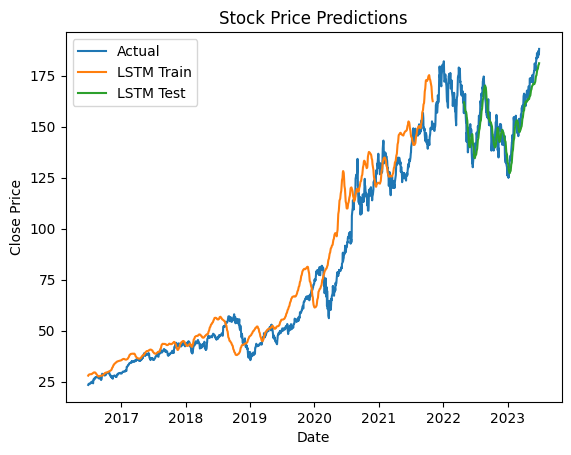

In [58]:
# Plot the actual data
plt.plot(data.index, data["Close"], label="Actual")

# Plot the LSTM predictions
plt.plot(data.index, train_predictions_padded, label="LSTM Train")
plt.plot(data.index, test_predictions_padded, label="LSTM Test")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Predictions")
plt.legend()
plt.show()


In [59]:
# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(time_steps, 1)))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Scale back the predictions to the original range
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Pad the predictions with NaN values to align with the original data
train_predictions_padded = np.empty_like(data["Close"].values)
train_predictions_padded[:len(train_predictions)] = train_predictions.ravel()
train_predictions_padded[len(train_predictions):] = np.nan

test_predictions_padded = np.empty_like(data["Close"].values)
test_predictions_padded[-len(test_predictions):] = test_predictions.ravel()
test_predictions_padded[:-len(test_predictions)] = np.nan


2023-06-28 10:22:13.344813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 10:22:13.345896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 10:22:13.346885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-28 10:22:13.692895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 10:22:13.694208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 10:22:13.695518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/43 [==============================] - 3s 25ms/step - loss: 0.0163
Epoch 2/10
43/43 [==============================] - 1s 24ms/step - loss: 2.6434e-04
Epoch 3/10
43/43 [==============================] - 1s 25ms/step - loss: 2.0147e-04
Epoch 4/10
43/43 [==============================] - 1s 25ms/step - loss: 2.0019e-04
Epoch 5/10
43/43 [==============================] - 1s 24ms/step - loss: 1.8223e-04
Epoch 6/10
43/43 [==============================] - 1s 24ms/step - loss: 1.7878e-04
Epoch 7/10
43/43 [==============================] - 1s 24ms/step - loss: 2.1048e-04
Epoch 8/10
43/43 [==============================] - 1s 25ms/step - loss: 1.7497e-04
Epoch 9/10
43/43 [==============================] - 1s 24ms/step - loss: 1.6099e-04
Epoch 10/10
43/43 [==============================] - 1s 24ms/step - loss: 1.5322e-04


2023-06-28 10:22:26.500023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-28 10:22:26.500870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-28 10:22:26.502052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

10/10 [==============================] - 0s 6ms/step


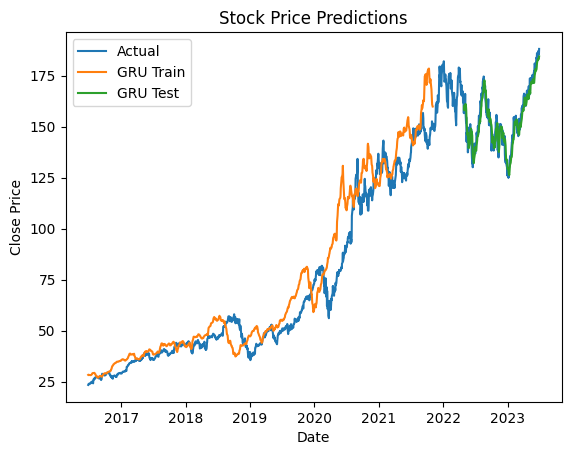

In [60]:
# Plot the actual data
plt.plot(data.index, data["Close"], label="Actual")

# Plot the GRU predictions
plt.plot(data.index, train_predictions_padded, label="GRU Train")
plt.plot(data.index, test_predictions_padded, label="GRU Test")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Predictions")
plt.legend()
plt.show()


In [61]:
# Prepare the data for ARIMA
train_data_arima = train_data["Close"].values
test_data_arima = test_data["Close"].values

# Train the ARIMA model
model = ARIMA(train_data_arima, order=(3, 1, 2))
model_fit = model.fit()

# Make predictions
train_predictions = model_fit.predict(start=1, end=len(train_data_arima)-1, typ='levels')
test_predictions = model_fit.predict(start=len(train_data_arima), end=len(train_data_arima)+len(test_data_arima)-1, typ='levels')

# # Make predictions
# train_predictions = model_fit.predict(start=1, end=len(train_data_arima)-1, typ='levels')
# test_predictions = model_fit.predict(start=len(train_data_arima), end=len(train_data_arima)+len(test_data_arima)-1, typ='levels')
#
# # Pad the predictions with NaN values to align with the original data
# train_predictions_padded = np.empty_like(data["Close"].values)
# train_predictions_padded[time_steps+1:time_steps+1+len(train_predictions)] = train_predictions
# train_predictions_padded[:time_steps+1] = np.nan
#
# test_predictions_padded = np.empty_like(data["Close"].values)
# test_predictions_padded[time_steps+1+len(train_predictions)+1:] = test_predictions
# test_predictions_padded[time_steps+1:time_steps+1+len(train_predictions)+1] = np.nan


ValueError: x and y must have same first dimension, but have shapes (292,) and (353,)

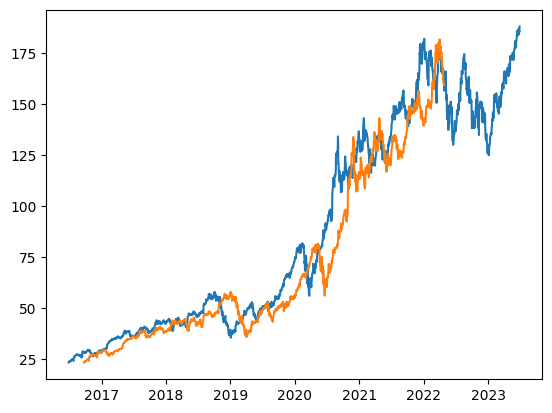

In [62]:
# Plot the actual data
plt.plot(data.index, data["Close"], label="Actual")

# Plot the ARIMA predictions
plt.plot(data.index[time_steps+1:time_steps+1+len(train_predictions)], train_predictions, label="ARIMA Train")
plt.plot(data.index[time_steps+1+len(train_predictions)+1:], test_predictions, label="ARIMA Test")

# plt.plot(data.index, train_predictions_padded, label="ARIMA Train")
# plt.plot(data.index, test_predictions_padded, label="ARIMA Test")

plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Stock Price Predictions")
plt.legend()
plt.show()
